In [1]:
include("graph_ops.jl")
using LinearAlgebra

function dense(w, b, x, activation) return activation(w * x .+ b) end
function dense(w, x, activation) return activation(w * x) end
function dense(w, x) return w * x end

function mean_squared_loss(y, ŷ)
    return ConstantNode(0.5) .* ((y .- ŷ) .^ ConstantNode(2))
end

function net(x, wh, wo, y)
    x̂ = dense(wh, x, tanh)
    ŷ = dense(wo, x̂)
    E = mean_squared_loss(y, ŷ)

    return topological_sort(E), ŷ
end

function net2(x, wh, bias, wo, y)
    x̂ = dense(wh, bias, x, tanh)
    ŷ = dense(wo, x̂)
    E = mean_squared_loss(y, ŷ)

    return topological_sort(E), ŷ
end


net2 (generic function with 1 method)

In [2]:
Wh  = VariableNode(randn(10,1))
Wh2  = VariableNode(randn(1,10))
Wo  = VariableNode(randn(1,10))
bias = VariableNode(randn(10,1))
x = InputNode([4.434])
y = InputNode([0.064])
losses = Float64[]



graph, target = net2(x, Wh,bias, Wo, y)
# graph, target = net2(x, Wh,Wh2, Wo, y)

init_nodes!(graph)


init_node! OperationNode{typeof(mul!)}
input sizes: Tuple{Int64, Vararg{Int64}}[(10, 1), (1,)]
number of inputs: 2
init_node-successful! OperationNode{typeof(mul!)}
init_node! OperationNode{typeof(+)}
input sizes: Tuple{Int64, Vararg{Int64}}[(10,), (10, 1)]
number of inputs: 2
init_node-successful! OperationNode{typeof(+)}
init_node! OperationNode{typeof(tanh)}
input sizes: [(10, 1)]
number of inputs: 1
init_node-successful! OperationNode{typeof(tanh)}
init_node! OperationNode{typeof(mul!)}
input sizes: [(1, 10), (10, 1)]
number of inputs: 2
init_node-successful! OperationNode{typeof(mul!)}
init_node! OperationNode{typeof(-)}
input sizes: Tuple{Int64, Vararg{Int64}}[(1,), (1, 1)]
number of inputs: 2
init_node-successful! OperationNode{typeof(-)}
init_node! OperationNode{typeof(^)}
input sizes: Tuple{Int64, Vararg{Int64}}[(1, 1), (1,)]
number of inputs: 2
init_node-successful! OperationNode{typeof(^)}
init_node! OperationNode{typeof(*)}
input sizes: Tuple{Int64, Vararg{Int64}}[(1,), (1,

In [3]:
import Base: sin
data = [([i], [sin(i)]) for i in 0:0.1:7]

71-element Vector{Tuple{Vector{Float64}, Vector{Float64}}}:
 ([0.0], [0.0])
 ([0.1], [0.09983341664682815])
 ([0.2], [0.19866933079506122])
 ([0.3], [0.29552020666133955])
 ([0.4], [0.3894183423086505])
 ([0.5], [0.479425538604203])
 ([0.6], [0.5646424733950354])
 ([0.7], [0.644217687237691])
 ([0.8], [0.7173560908995228])
 ([0.9], [0.7833269096274834])
 ⋮
 ([6.2], [-0.0830894028174964])
 ([6.3], [0.016813900484349713])
 ([6.4], [0.11654920485049364])
 ([6.5], [0.21511998808781552])
 ([6.6], [0.31154136351337786])
 ([6.7], [0.4048499206165983])
 ([6.8], [0.49411335113860816])
 ([6.9], [0.5784397643882002])
 ([7.0], [0.6569865987187891])

In [7]:
n_epochs = 100
lr = 0.01
data_size = length(data)
losses = Float64[]
Wh_acc_gradient = zeros(size(Wh.output))
bias_acc_gradient = zeros(size(bias.output))
Wo_acc_gradient = zeros(size(Wo.output))

@time for epoch in 1:n_epochs
    fill!(Wh_acc_gradient, 0)
    fill!(Wo_acc_gradient, 0)
    loss_in_epoch = 0
    for (x_, y_) in data
        x.output = x_
        y.output = y_
        currentloss = forward!(graph)
        backward!(graph)
        loss_in_epoch += first(currentloss)
    end
    Wh_acc_gradient .+= Wh.gradient
    bias_acc_gradient .+= bias.gradient
    Wo_acc_gradient .+= Wo.gradient
    Wh.output .-= lr*(Wh_acc_gradient ./ data_size)
    bias_acc_gradient .-= lr*(bias_acc_gradient ./ data_size)
    Wo.output .-= lr*(Wo_acc_gradient ./ data_size)
    reset!(graph)
    println("Current loss: ", loss_in_epoch/data_size)
    push!(losses, first(loss_in_epoch/data_size))
end


In [5]:
import Base: sin
data_dense_x = 0:0.1:7
data_dense_y = sin.(data_dense_x)

using Plots
xx = 0:0.01:7
yy = Vector{Float64}(undef, length(xx))

701-element Vector{Float64}:
 6.986219553026e-312
 6.986219553263e-312
 6.9862195535e-312
 6.986219554923e-312
 6.98621955516e-312
 6.986219555397e-312
 6.986219555634e-312
 6.98621955587e-312
 6.98621955611e-312
 6.986219556346e-312
 ⋮
 6.98622183118e-312
 6.98622183142e-312
 6.986221831656e-312
 6.986221831894e-312
 6.98622183213e-312
 6.98622183237e-312
 6.986221832605e-312
 0.0
 0.0

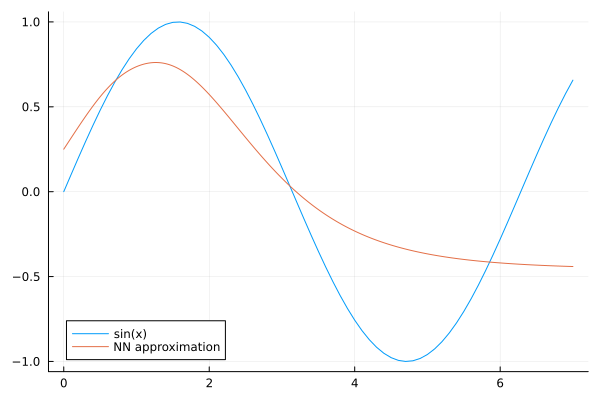

In [10]:


for i in 1:length(xx)
    yy[i] = predict!([xx[i]], x,target, graph)[1]
end

plot(data_dense_x, data_dense_y, label="sin(x)")
plot!(xx, yy, label="NN approximation")
